In [1]:
show_even_wrong_end_data = True

show_epoch = True
show_timepoint = False 

use_colored_kde=False

In [ ]:
'''
Adapted from:
https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b

This script exctracts variables from all logs from 
tensorflow event files ("event*"), writes them to Pandas.
'''

import tensorflow as tf
import glob
import os
import pandas as pd
import numpy as np
from math import ceil 

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Extraction function
def sum_log(path, runlog, nbr_epochs=20):
    steps = {}
    nbr_steps_per_epoch = {}
    try:
        for timepoint, e in enumerate(tf.train.summary_iterator(path)):
            for v in e.summary.value:
                if v.tag not in steps: steps[v.tag] = 0
                runlog['metric'].append(v.tag)
                runlog['value'].append(v.simple_value)
                runlog['timepoint'].append(timepoint)
                runlog['source'].append(path)
                runlog['step'].append(steps[v.tag])
                runlog['epoch'].append(-1)
                steps[v.tag] += 1
                
    except Exception as e:
        print(f"Exception caught: {e}")
    
    need_to_retrieve_latest_value = {}
    for key in set(runlog["metric"]):
        nbr_steps = steps[key]
        e_nbr_epochs = min(nbr_steps,nbr_epochs)
            
        eucl_div = nbr_steps//e_nbr_epochs
        div = nbr_steps/e_nbr_epochs
        if eucl_div == div:
            nbr_steps_per_epoch[key] = nbr_steps//e_nbr_epochs
            need_to_retrieve_latest_value[key] = False
        else:
            nbr_steps_per_epoch[key] = ceil(nbr_steps/e_nbr_epochs)
            need_to_retrieve_latest_value[key] = True
            
    for idx, step in enumerate(runlog['step']):
        key = runlog['metric'][idx]
        if (step+1)%nbr_steps_per_epoch[key]==0\
            or (show_even_wrong_end_data and step+1==steps[key] and need_to_retrieve_latest_value[key]):
            runlog['epoch'][idx] = (step+1)//nbr_steps_per_epoch[key]-1
    
    return runlog

In [ ]:
def glob_data(path):
    seed_splitted_path = path.split('SEED')
    hyph_splitted_path = seed_splitted_path[1].split('-',maxsplit=1)[1]
    path = os.path.join(seed_splitted_path[0]+'SEED*-'+hyph_splitted_path)
    
    event_paths = glob.glob(path)    
    event_paths = glob.glob(os.path.join(path, "event*"))
    for p in event_paths:
        print(p)
        print('-'*20)
    
    df_runs = {'metric':[], 'value':[], 'timepoint':[], 'step':[], 'source':[], 'epoch':[]}
    
    for path in event_paths:
        sum_log(path,df_runs)
    
    return pd.DataFrame(df_runs)

In [194]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, percentage=False):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter
    
    def colored_kde(x, y, c=None):
        def kde(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
                kwargs['kind']='kde'
                kwargs['alpha']=0.5
                kwargs['legend']=True
            sns.kdeplot(*args, **kwargs)
        
        return kde 
    
    bottom = 0.1
    top = 1.1
    if percentage:
        bottom = -5.0
        top = 105.0
        
    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df,
        xlim=(bottom,top),
        ylim=(bottom,top)
    )
    
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        
        if not(use_colored_kde):
            g.plot_joint(
                colored_scatter(df_group[col_x],df_group[col_y],color),
            )
        else:
            g.plot_joint(
                colored_kde(df_group[col_x],df_group[col_y],color),
            )
        
        '''
        sns.kdeplot(df_group[col_x],df_group[col_y],
                     #hue=hue,
                     #style=None,
                     #err_style=err_style, #"bars", 
                     #ci=ci, #68
                     kind='kde',
                     #data=run_df.loc[run_df['exp'].isin(['interweaved'])],
                     color=color,
                     ax=g.ax_joint,
                     alpha=0.5,
                     #shade=True
                     #linewidth=linewidth,
                     legend=True,
                    )
        '''
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            kde=True,
            hist=False
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,
            kde=True,
            hist=False,
            vertical=True
        )
        #g = g.plot_marginals(sns.kdeplot, shade=True)
    
    '''
    # Do also global Hist:
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    '''
    plt.legend(legends)
    
    bottom=0
    top=100
    #sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=g.ax_joint)    
    

def filtered_graph(df_runs, filtering_keys, 
                   logscale=False,
                   ci='sd',
                   err_style='band',
                   linewidth=2,
                   hue="metric",
                   style=None,
                   nbr_epochs=20,
                   percentage=False):
    
    filtering = lambda df: df['metric'].isin(filtering_keys)
    filtered_df_run = df_runs[filtering(df_runs)]
    
    x_column = 'step'
    if show_timepoint:
        x_column = 'timepoint'
        
    test_keys = [k for k in filtering_keys if 'test' in k]
    train_keys = [k for k in filtering_keys if 'train' in k]
    comparing_test_train = (len(test_keys) * len(train_keys))
    if show_epoch and comparing_test_train:
        # Make sure that the graph are epoch-aligned, for easier comparaison:
        x_column = 'epoch'
        epoch_indices = range(nbr_epochs)
        epoch_filtering = lambda df: df['epoch'].isin(epoch_indices)
        filtered_df_run = filtered_df_run[epoch_filtering(filtered_df_run)]
        
    fig, ax = plt.subplots()
    if logscale:
        ax.set(yscale="log")
    
    bottom = 0.0
    top = 1.0
    if percentage:
        bottom = 0.0
        top = 100.0
    ax.set_ylim(bottom, top)

    g = sns.lineplot(x=x_column, 
              y="value",
             hue=hue,
             style=style,
             err_style=None,#err_style, #"bars", 
             ci=ci, #68
             data=filtered_df_run,
             ax=ax,
             linewidth=linewidth)
    
    if comparing_test_train:
        ps = []
        x_column = "train"
        y_column = "test"
        
        for test_key, train_key in zip(test_keys, train_keys):
            df = filtered_df_run.copy()
            
            #run_d = {'epoch':df.loc[df['metric'].isin([epoch_key]), 'epoch'].values}
            run_d = {}
            run_d['train'] = df.loc[df['metric'].isin([train_key]), 'value'].values
            run_d['test'] = df.loc[df['metric'].isin([test_key]), 'value'].values
            
            if show_even_wrong_end_data:
                min_length = min(len(run_d['train']), len(run_d['test']))
                run_d['train'] = df.loc[df['metric'].isin([train_key]), 'value'].values[:min_length]
                run_d['test'] = df.loc[df['metric'].isin([test_key]), 'value'].values[:min_length]

            hue = None
            if 'exp' in df.keys():
                run_d['exp'] = df.loc[df['metric'].isin([test_key]), 'exp'].values[:min_length]
                hue = 'exp'
            
            run_df = pd.DataFrame(run_d)
            
            fig_ps, ax_ps = plt.subplots()
            
            bottom = 0.0
            top = 1.0
            if percentage:
                bottom = 0.0
                top = 100.0
            ax_ps.set_ylim(bottom, top)
            ax_ps.set_xlim(bottom, top)
            sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)    

            p = sns.lineplot(x=x_column, 
                 y=y_column,
                 hue=hue,
                 style=None,
                 err_style=err_style, #"bars", 
                 ci=ci, #68
                 data=run_df,
                 ax=ax_ps,
                 linewidth=linewidth)
            
            try:
                if hue is not None:
                    fig_ps, ax_ps = plt.subplots()

                    bottom = 0.0
                    top = 1.0
                    if percentage:
                        bottom = 0.0
                        top = 100.0
                    ax_ps.set_ylim(bottom, top)
                    ax_ps.set_xlim(bottom, top)
                    sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)

                    sns.kdeplot(data=run_df.loc[run_df['exp'].isin(['interweaved'])].train,
                         #x_column, 
                         data2=run_df.loc[run_df['exp'].isin(['interweaved'])].test,
                         #y_column,
                         #hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         kind='kde',
                         #data=run_df.loc[run_df['exp'].isin(['interweaved'])],
                         color='red',
                         ax=ax_ps,
                         alpha=0.5,
                         #shade=True
                         #linewidth=linewidth
                        )

                    sns.kdeplot(data=run_df.loc[run_df['exp'].isin(['splitted'])].train,
                         #x_column, 
                         data2=run_df.loc[run_df['exp'].isin(['splitted'])].test,
                         #y_column,
                         #hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         kind='kde',
                         #data=run_df.loc[run_df['exp'].isin(['splitted'])],
                         ax=ax_ps,
                         color='blue',
                         alpha=0.5,
                         #shade=True
                         #linewidth=linewidth
                        )

                    '''
                    fig_ps, ax_ps = plt.subplots()

                    bottom = 0.0
                    top = 1.0
                    if percentage:
                        bottom = 0.0
                        top = 100.0

                    ax_ps.set_ylim(bottom, top)
                    ax_ps.set_xlim(bottom, top)
                    sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)

                    sns.relplot(x=x_column, 
                         y=y_column,
                         hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         #kind='kde',
                         data=run_df,#run_df.loc[run_df['exp'].isin(['interweaved'])],
                         ax=ax_ps,
                         alpha=0.5,
                         #palette='muted',
                         #shade=True
                         #linewidth=linewidth
                        )
                    '''

                    p = multivariateGrid(col_x=x_column, 
                                         col_y=y_column, 
                                         col_k=hue, 
                                         df=run_df, 
                                         k_is_color=False, 
                                         scatter_alpha=.5,
                                         percentage=percentage)
            except Exception as e:
                    print(e)
            ps.append(p)
        return g, ps
    else:
        return g

In [166]:
def glob_filter_draw(path, metrics, df_runs=None, percentage=False):
    if df_runs is None:
        df_runs = glob_data(path)
    g = filtered_graph(df_runs, metrics, percentage=percentage)
    return g, df_runs

In [167]:
def glob_filter_draw_acc4path(path, percentage=True):
    acc = ['test/Accuracy', 'train/Accuracy']
    init_path = '/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/'
    path = os.path.join(init_path,path)
    g_acc, df_runs = glob_filter_draw(path, acc, percentage=percentage)
    return g_acc, df_runs

## Introduction

As explained earlier, our work is to be understood towards building **efficiently** situated life-long learning communicating and task-performing agents, thus sample-efficiency is of paramount importance. It can be linked to compositionality and the ability to understand algebraic rule-based generalization in a systematic manner in two ways. Firstly in terms of the actual number of variations shown in the data (can be referred as data-efficiency), and secondly in terms of the time-efficiency of the learning (how many times were the data presented for the system to learn from it?)

(Lake and Baroni, 2018) introduces the SCAN dataset and related experiments as a benchmark for few-shot learning of "meaningful new-word embeddings" (\cite{Loula et al. 2018}) with RNNs. As a follow-up, (Loula et al., 2018) repurposes this dataset in new experiments (via new train/test splits) as a benchmark for zero-shot learning of compositional stimuli whose components are familiar, i.e. "the network needs only to recombine well-trained functional words"(\cite{Loula et al. 2018}).

Both works pile up arguments towards the conclusion that "RNNs do show a considerable degree of generalization", "but only when they receive extensive training on the specific pattern to be generalized"(\cite{Loula et al. 2018}) and, most interestingly, that they lack systemacity when it comes to learning algebraic rule-based compositionality. 

In the context of referential games, stimuli are usually of another modality than textual. Here we will focus on visual referential games where the stimuli modality is made up of pixels. 
Note that in the context of referential games, sample-efficiency takes a whole different level of meaning when considering that a sample (as seen by the listener) consist of a specific set of stimuli, and not a specific target stimuli. The same target can be seen in comparaison to many different --altogether a limited number thoug (more on this when tackling the *poverty of stimulus* paradigm)-- distractors. To remove the ambiguity of having to control for different distractors everytime each target is shown, we assume random distractors sampling and refer to a sample as a set of stimuli experience by the listener at each timestep.
Given our emphasis on data-efficiency, we ask to what extent a compositional language can emerge with a very limited number of samples --of the size that can actually be gathered by a single agent in a few minutes worth of experimenting in the environment it is situated in--.

We assume that it is thus important to benchmark neural network in the visual domain on their ability to generalize compositionaly. In the following, we propose to benchmark for zero-shot learning of compositional stimuli whose components are familiar in the visual domain, testing CNN-based architectures. We propose multiple train/test splits to the dSprites dataset (\cite{Higgins2017} ?) and show that:

+ (i) (common (basic CNN) and state-of-the-art (ResNet))CNN-based architectures also lack systemacity when it comes to learning algebraic rule-based compositionality (in another setting here, but much similarly to the results shown by (\cite{CoordConvUberPaper} --> investigate CoordConv CNNs in those splits: expect no differences), --as evidenced by the fact that their generalization abilities only ramps up with the density of the data that their are being shown (right? test for increase of density in the dataset)--

+ (ii) (common...) CNN-based architectures are sensible to the kind of train/test split proposed --as evidenced by the sensible overfitting/decrease of performance between the 'splitted' and 'interweaved' train/test splits--. (it might be interesting to consider testing both train/test split on both same test sets?)  

# Experiment 1: Interpolation to novel compositional stimuli with familiar components: effect of the train/test split

### ResNet18-2:

+ 'splitted' set:

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED10-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2/events.out.tfevents.1582889105.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffO

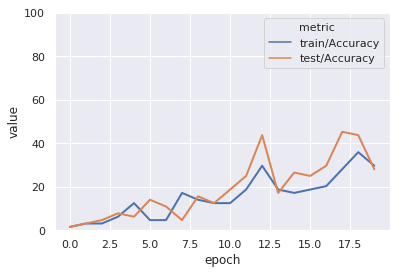

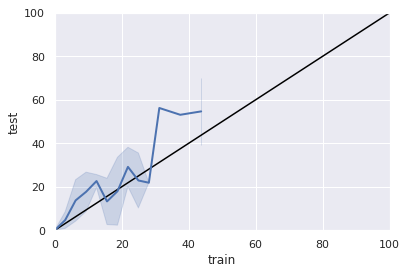

In [168]:
path_split = 'PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED20-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2'
g_acc_split, df_runs_split = glob_filter_draw_acc4path(path_split)

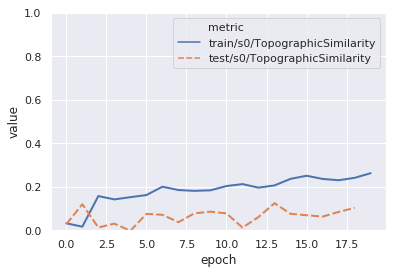

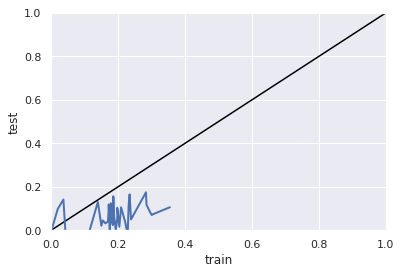

In [169]:
 
g_test_TS_split = filtered_graph(df_runs_split,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=False)

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED10-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2/events.out.tfevents.1582884900.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObver

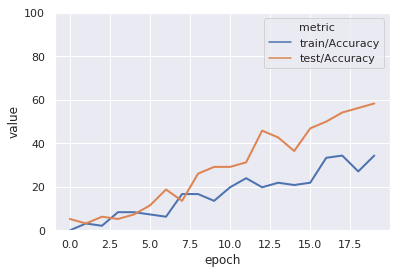

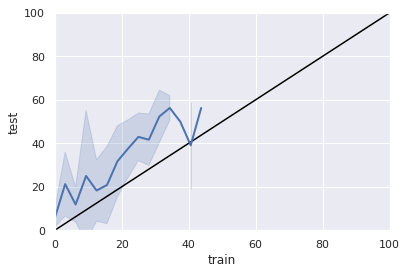

In [170]:
path_inter = 'PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED20-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2'
g_acc_inter, df_runs_inter = glob_filter_draw_acc4path(path_inter)

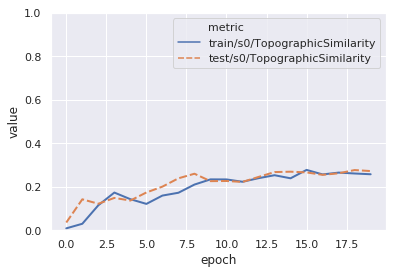

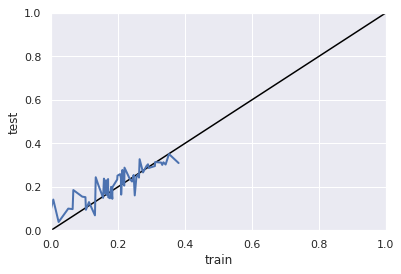

In [171]:
g_test_TS_inter = filtered_graph(df_runs_inter,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=False)

In [172]:
split_length = len(df_runs_split['value'])
df_runs_split_id = df_runs_split.assign(exp=pd.Series(['splitted']*split_length))
inter_length = len(df_runs_inter['value'])
df_runs_inter_id = df_runs_inter.assign(exp=pd.Series(['interweaved']*inter_length))

combined_df_runs_inter_split = pd.concat([df_runs_split_id, df_runs_inter_id])
                                         
for metric in set(combined_df_runs_inter_split['metric']):
    print(metric)

train/WeightMaxL1Loss
train/s0/TopographicSimilarity
test/Loss
train/s0/multi_head_0_loss
train/Entropy
train/referential_game_loss
train/s0/multi_head_2_loss
test/speaker/s0/multi_head_0_accuracy
train/speaker/s0/multi_head_3_accuracy
test/Entropy
train/s0/multi_head_3_loss
test/s0/multi_head_5_loss
train/speaker/s0/multi_head_4_accuracy
train/s0/multi_head_5_loss
test/WeightMaxL1Loss
train/Accuracy
test/speaker/s0/multi_head_3_accuracy
test/s0/multi_head_1_loss
train/s0/multi_head_4_loss
train/speaker/s0/multi_head_0_accuracy
test/speaker/s0/multi_head_1_accuracy
test/Ambiguity____
test/s0/multi_head_4_loss
train/Tau/Speaker/Mean
test/speaker/s0/multi_head_2_accuracy
train/Ambiguity____
test/referential_game_loss
test/s0/TopographicSimilarity
test/Stimulus/Mean
train/speaker/s0/multi_head_5_accuracy
test/Accuracy
test/SentenceLength__/10_
train/Loss
train/SentenceLength__/10_
train/s0/TopographicSimilarity-UniqueProduction
test/s0/multi_head_2_loss
test/speaker/s0/multi_head_4_accura

### CNN-based architectures: Ability to generalize compositionally to novel compositional stimuli with familiar components

singular matrix
singular matrix


/home/kevin/anaconda3/envs/RG/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


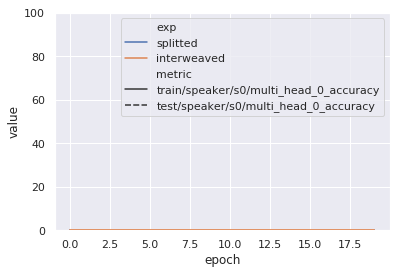

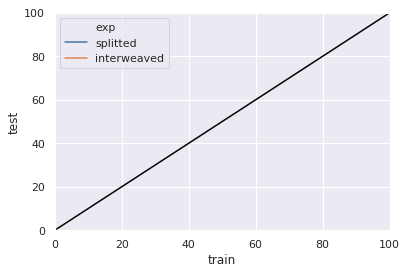

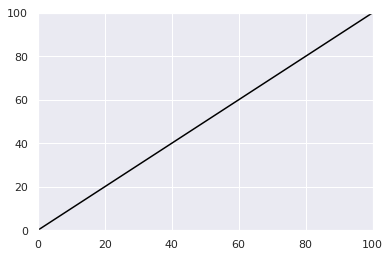

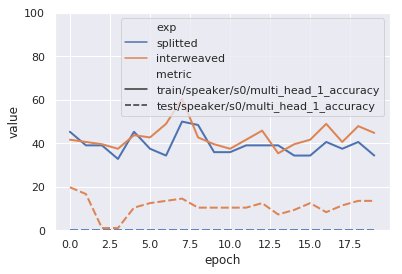

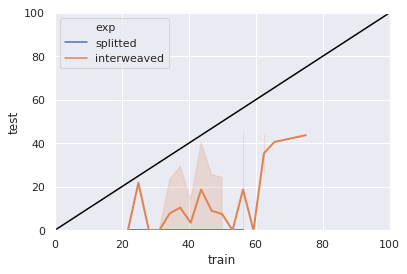

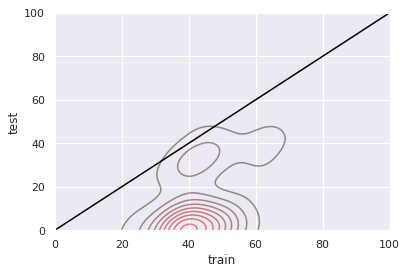

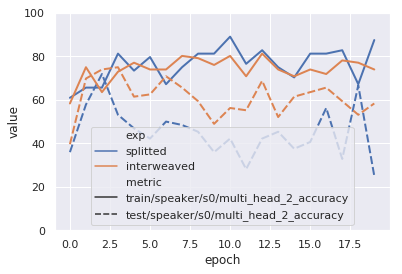

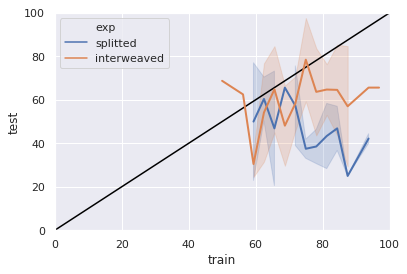

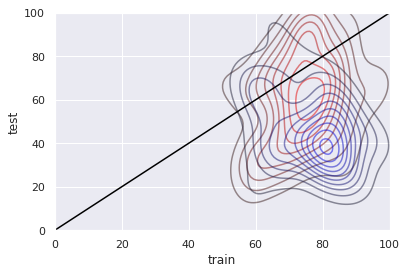

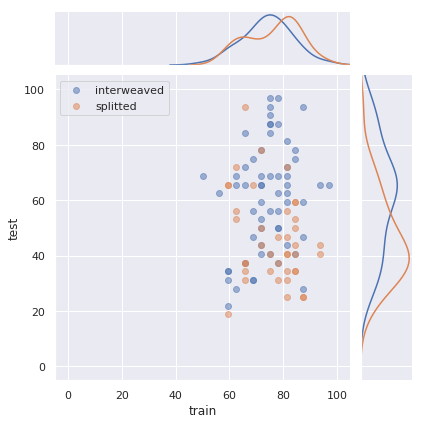

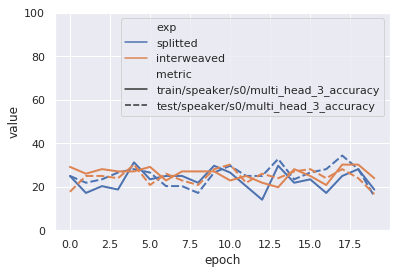

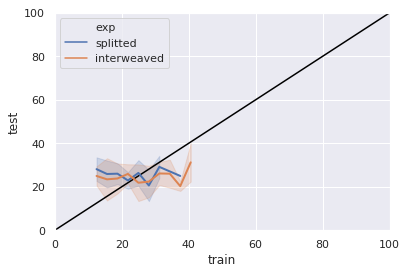

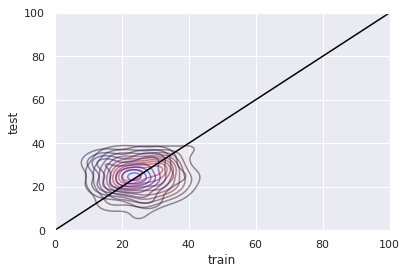

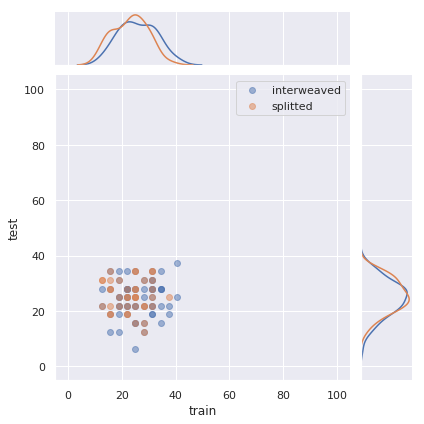

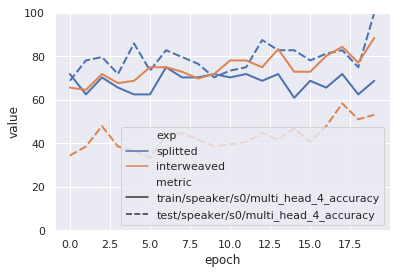

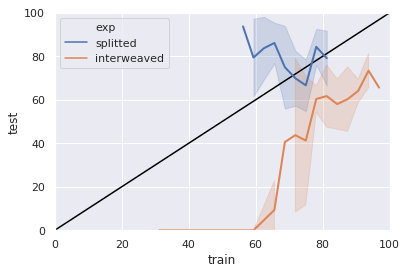

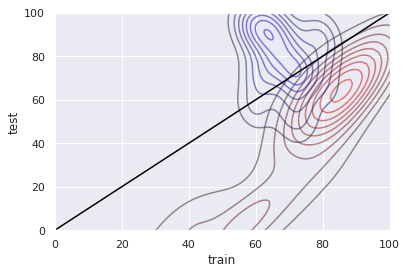

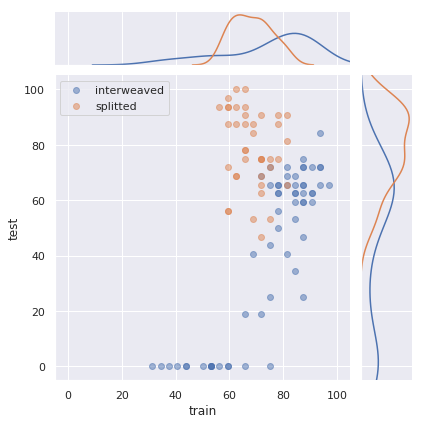

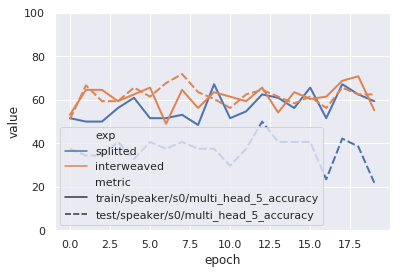

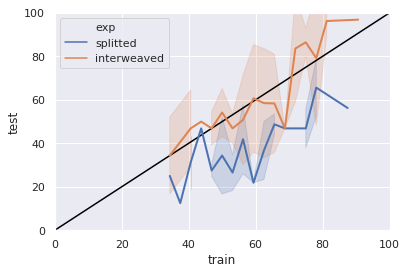

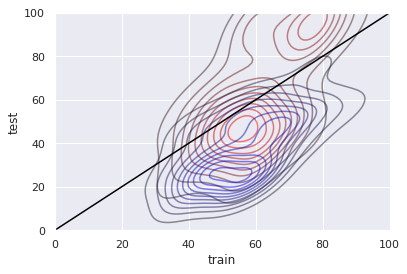

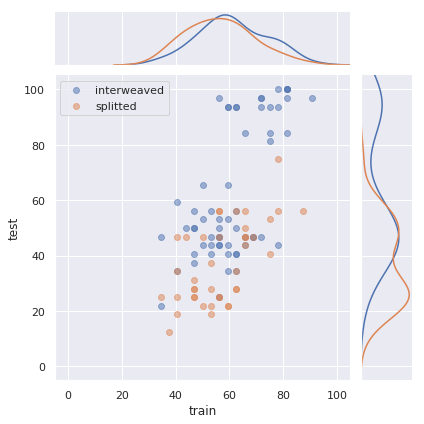

In [173]:
g_test_LatentPrediction_split_vs_inter = {}
for i_head in range(6):
    g_test_LatentPrediction_split_vs_inter[i_head] = filtered_graph(pd.concat([df_runs_split_id, df_runs_inter_id]),
                   filtering_keys=[f"test/speaker/s0/multi_head_{i_head}_accuracy", f"train/speaker/s0/multi_head_{i_head}_accuracy"], 
                   logscale=False,
                   ci='sd',
                   err_style='band',
                   linewidth=2,
                   hue="exp",
                   style="metric",
                   percentage=True)

#### Details of the benchmark:

Zero-shot learning to compositional stimuli with familiar components is benchmarked here by removing stimuli of the form "ANY_COLOR | Heart | ANY_SCALE | ANY_ORIENTATION | X_in_{} | Y_in_{}" where X_in_{} and Y_in_{} depend on the train/test split.

In the 'splitted' split, POS_in_{} corresponds to all the position on the top left corner of the image, whereas in the 'interweaved' split, it corresponds to regularly spaced out positions throughout the whole image.

#### Results:

Despite the fact that the position-related latents are not showing much variations between the train and the test results --thus hinting at the fact that (maybe?) CNN-based architecture are able to generalize compositionally to that kind of variation (more on this later: idea that it might just be that they have had enough examples to do so, and/or that they do have the relevant biases to do so + factoring the fact that this is only a probe to what the CNN has learned so far using the RG loss function!!!!! + factoring the fact that the data-density of each value is different from one latent axis to another, i.e. only 3 values are seen on the SHAPE axis, while as much as 8 values are seen on the individual X/Y axises / 64 on the position axis!!!!)--, it is clear that a different story is being laid out with the SHAPE latent:

- (i) None of the train/test split achieved similar test accuracies than at training time, thus argumenting for the fact that this CNN-based architecture fails to generalize compositionally to component of SHAPE (object-type?), in this very limited setting.
- (ii) This kind of CNN-based architecture is only able to get itself off the ground when paired up with an 'interweaved' train/test split pattern, that shows a simpler kind of zero-shot learning [...] than in the case of 'splitted' split.

### Effect on Referential Game's Accuracy and Compositionality:

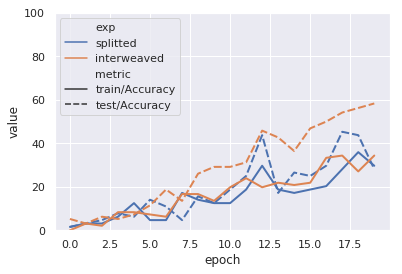

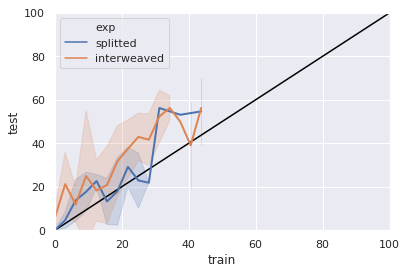

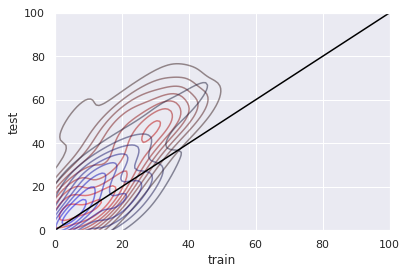

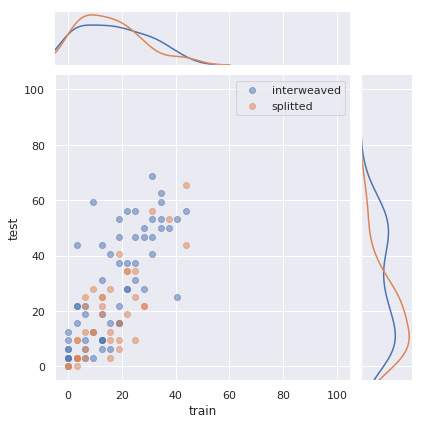

In [174]:
g_test_acc_split_vs_inter = filtered_graph(combined_df_runs_inter_split,
    filtering_keys=["test/Accuracy", "train/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True)

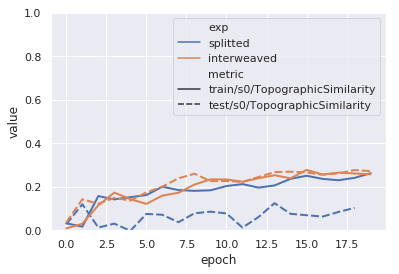

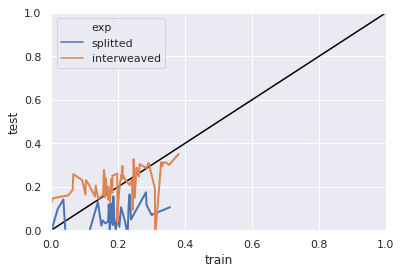

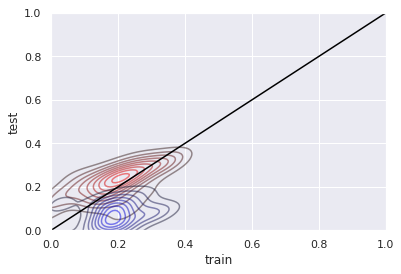

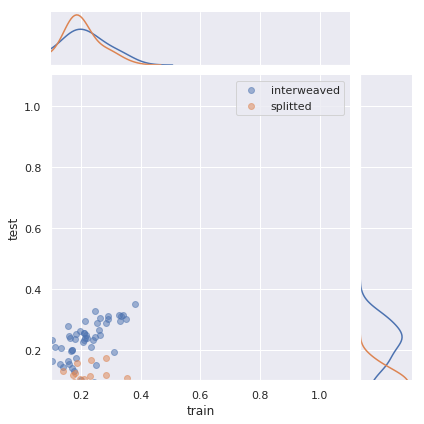

In [175]:
g_test_TS_split_vs_inter = filtered_graph(combined_df_runs_inter_split,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=False)

#### Results:

- (i) The difference between the train and test time TS, in the 'splitted' setting, clearly shows the lack of productivity that the emerging I-language would enables (i.e. measure compositionality in terms of the ability, at test time, to repurpose the language to novel stimuli, thus yielding a high TS measure for the test-time E-Language).

- (ii) Focusing on the accuracies, it would seem that the emerging language in the 'interweaved' setting allows the agent to generalize compositionally **when it comes to discriminating between stimuli**.


### Why is there seemingly compositional generalization when looking at the RG accuracy, while there is failure to do so when looking at the latent values prediction?

It most likely has to do with the latent axises difference in terms of value sampling size. The sampling size on the SHAPE latent axis is far smaller than that on the POSITION latent axis, which gives the architecture less opportunity to learn to generalize, thus showing that they do not generalize systematically, but rather that they pile up evidences, similarly to how RNNs do(\cite{Loula et al. 2018}).
The accuracies observed are a reflexion of the language being focused more on positioning than on shapes.

To give a greater sense of this, we test the same architecture with test samples that consist solely of stimuli of the shape (SAME_COLOR | Shapes_in_{} | SAME_SCALE | SAME_ORIENTATION | SAME_X | SAME_Y).


### CoordResNet:

+ 'splitted' set:

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/EXP1/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED30-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2/events.out.tfevents.1582948646.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/EXP1/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-Resetoldest

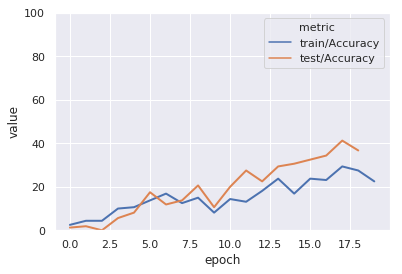

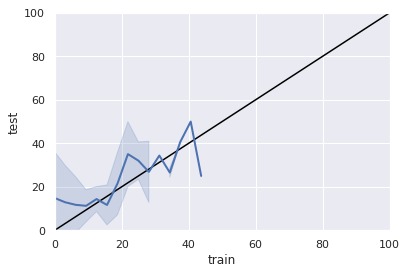

In [176]:
path_coord_split = 'PAPER/EXP1/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED50-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2'
g_acc_coord_split, df_runs_coord_split = glob_filter_draw_acc4path(path_coord_split)

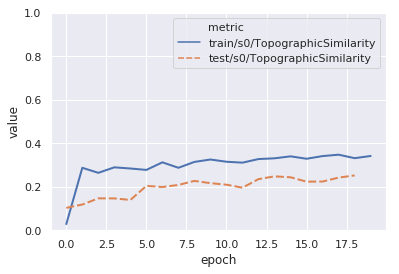

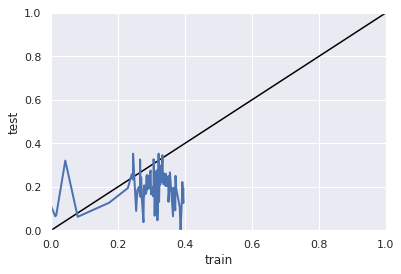

In [177]:
g_test_TS_coord_split = filtered_graph(df_runs_coord_split,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=False)

+ 'interweaved' set:

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED10-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2/events.out.tfevents.1582932302.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiff

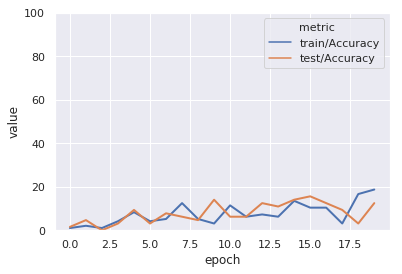

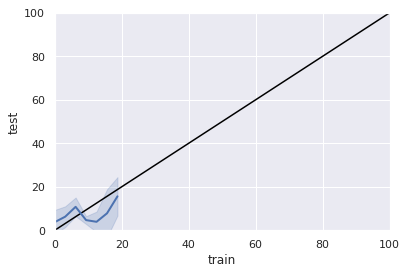

In [178]:
path_coord_inter = 'PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial3-Y-4-2-X-4-2-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED20-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2'
g_acc_coord_inter, df_runs_coord_inter = glob_filter_draw_acc4path(path_coord_inter)

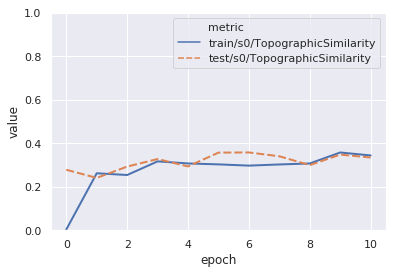

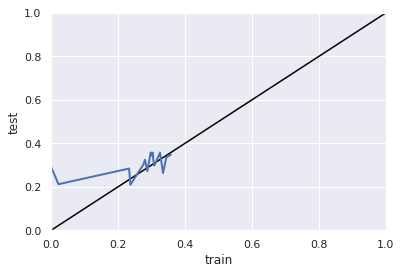

In [179]:
g_test_TS_coord_inter = filtered_graph(df_runs_coord_inter,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=False)

In [180]:
coord_split_length = len(df_runs_coord_split['value'])
df_runs_coord_split_id = df_runs_coord_split.assign(exp=pd.Series(['splitted']*coord_split_length))
coord_inter_length = len(df_runs_coord_inter['value'])
df_runs_coord_inter_id = df_runs_coord_inter.assign(exp=pd.Series(['interweaved']*coord_inter_length))

combined_df_runs_coord_inter_split = pd.concat([df_runs_coord_split_id, df_runs_coord_inter_id])
                                         
for metric in set(combined_df_runs_coord_inter_split['metric']):
    print(metric)

train/WeightMaxL1Loss
train/s0/TopographicSimilarity
test/Loss
train/s0/multi_head_0_loss
train/Entropy
train/referential_game_loss
train/s0/multi_head_2_loss
test/speaker/s0/multi_head_0_accuracy
train/speaker/s0/multi_head_3_accuracy
test/Entropy
train/s0/multi_head_3_loss
test/s0/multi_head_5_loss
train/speaker/s0/multi_head_4_accuracy
train/s0/multi_head_5_loss
test/WeightMaxL1Loss
train/Accuracy
test/speaker/s0/multi_head_3_accuracy
test/s0/multi_head_1_loss
train/s0/multi_head_4_loss
train/speaker/s0/multi_head_0_accuracy
test/speaker/s0/multi_head_1_accuracy
test/Ambiguity____
test/s0/multi_head_4_loss
train/Tau/Speaker/Mean
test/speaker/s0/multi_head_2_accuracy
train/Ambiguity____
test/referential_game_loss
test/s0/TopographicSimilarity
test/Stimulus/Mean
train/speaker/s0/multi_head_5_accuracy
test/Accuracy
test/SentenceLength__/10_
train/Loss
train/SentenceLength__/10_
train/s0/TopographicSimilarity-UniqueProduction
test/s0/multi_head_2_loss
test/speaker/s0/multi_head_4_accura

### CoordResNet-based architectures: Ability to generalize compositionally to novel compositional stimuli with familiar components

singular matrix
singular matrix


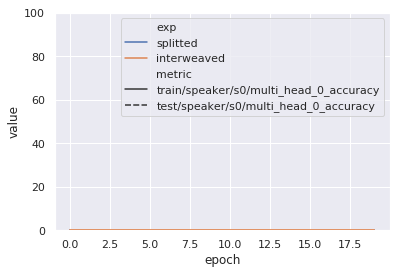

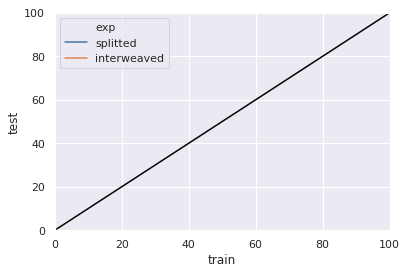

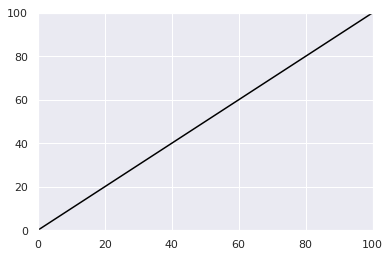

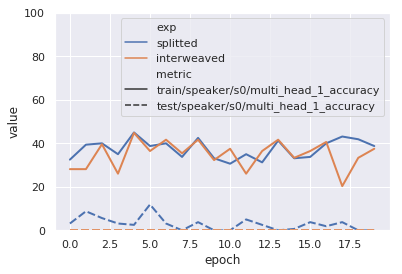

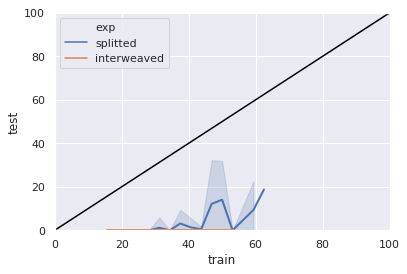

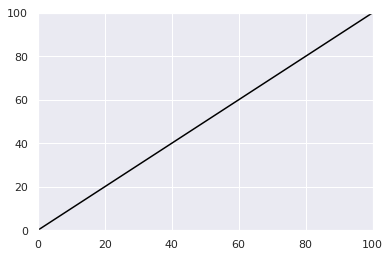

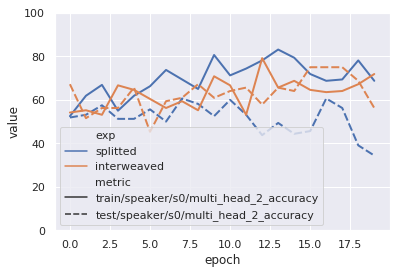

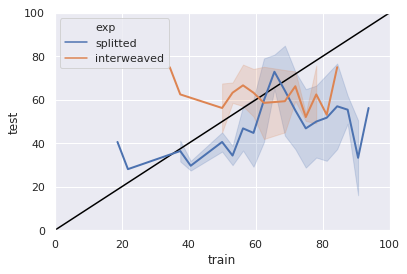

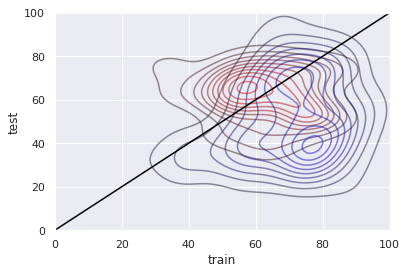

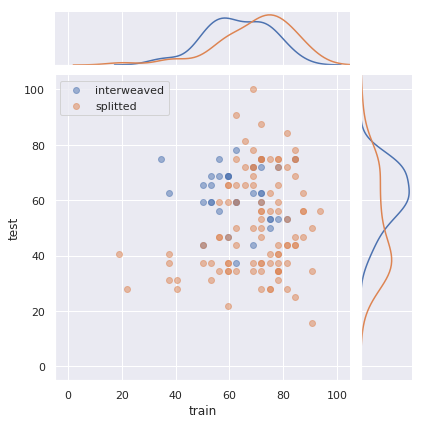

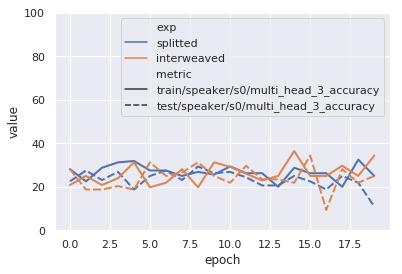

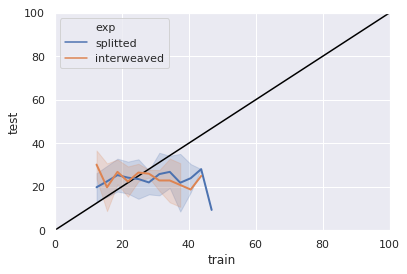

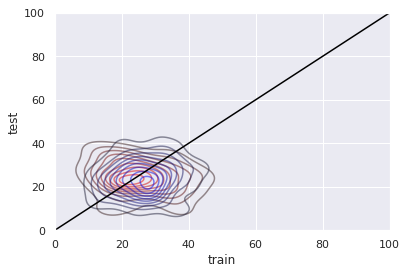

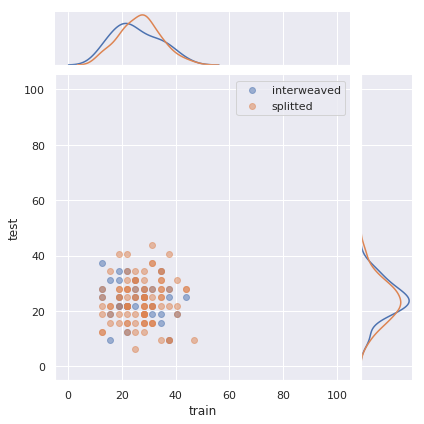

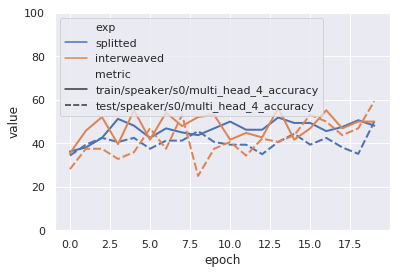

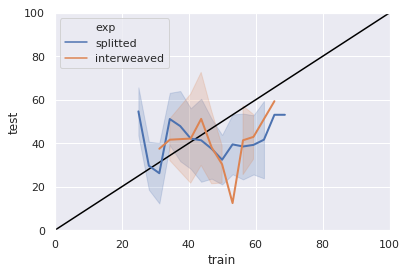

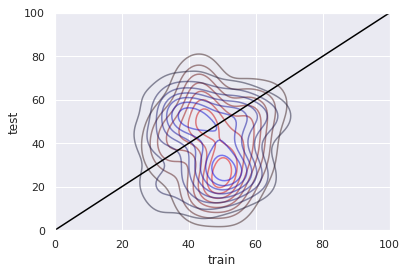

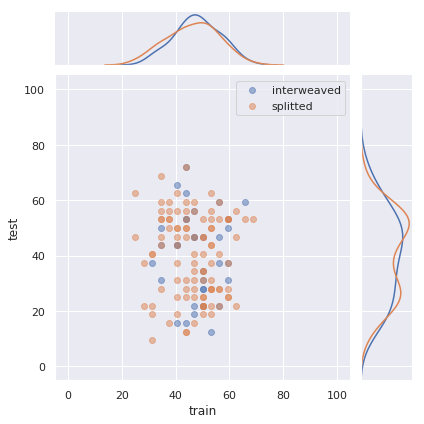

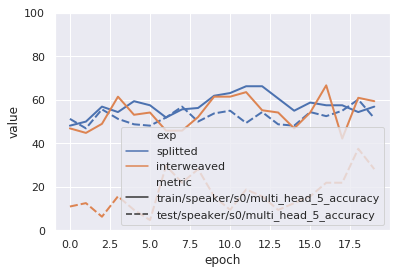

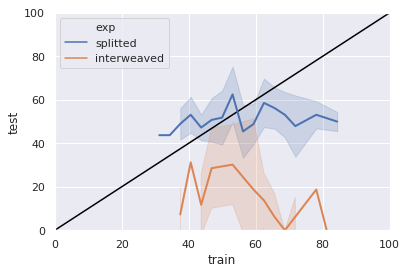

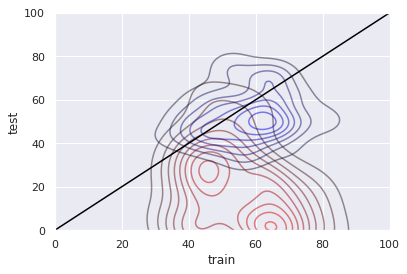

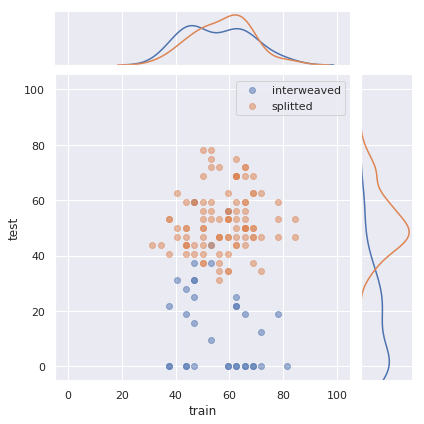

In [181]:
g_test_LatentPrediction_coord_split_vs_inter = {}
for i_head in range(6):
    g_test_LatentPrediction_coord_split_vs_inter[i_head] = filtered_graph(pd.concat([df_runs_coord_split_id, df_runs_coord_inter_id]),
                   filtering_keys=[f"test/speaker/s0/multi_head_{i_head}_accuracy", f"train/speaker/s0/multi_head_{i_head}_accuracy"], 
                   logscale=False,
                   ci='sd',
                   err_style='band',
                   linewidth=2,
                   hue="exp",
                   style="metric",
                   percentage=True)

#### Details of the benchmark:

Zero-shot learning to compositional stimuli with familiar components is benchmarked here by removing stimuli of the form "ANY_COLOR | Heart | ANY_SCALE | ANY_ORIENTATION | X_in_{} | Y_in_{}" where X_in_{} and Y_in_{} depend on the train/test split.

In the 'splitted' split, POS_in_{} corresponds to all the position on the top left corner of the image, whereas in the 'interweaved' split, it corresponds to regularly spaced out positions throughout the whole image.

#### Results:

Despite the fact that the position-related latents are not showing much variations between the train and the test results --thus hinting at the fact that (maybe?) CNN-based architecture are able to generalize compositionally to that kind of variation (more on this later: idea that it might just be that they have had enough examples to do so, and/or that they do have the relevant biases to do so + factoring the fact that this is only a probe to what the CNN has learned so far using the RG loss function!!!!! + factoring the fact that the data-density of each value is different from one latent axis to another, i.e. only 3 values are seen on the SHAPE axis, while as much as 8 values are seen on the individual X/Y axises / 64 on the position axis!!!!)--, it is clear that a different story is being laid out with the SHAPE latent:

- (i) None of the train/test split achieved similar test accuracies than at training time, thus argumenting for the fact that this CNN-based architecture fails to generalize compositionally to component of SHAPE (object-type?), in this very limited setting.
- (ii) This kind of CNN-based architecture is only able to get itself off the ground when paired up with an 'interweaved' train/test split pattern, that shows a simpler kind of zero-shot learning [...] than in the case of 'splitted' split.

### Effect on Referential Game's Accuracy and Compositionality: CoordResNet-based architecture

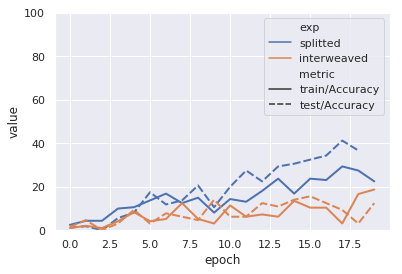

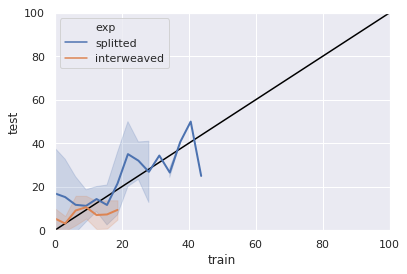

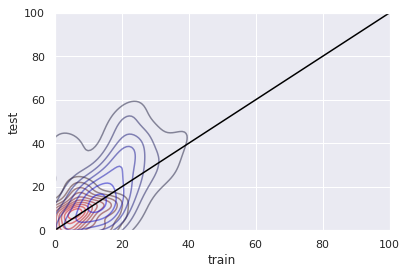

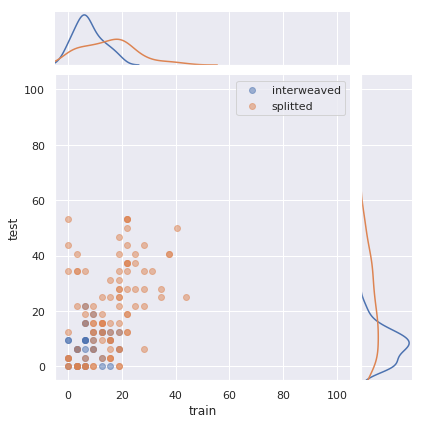

In [182]:
g_test_acc_coord_split_vs_inter = filtered_graph(combined_df_runs_coord_inter_split,
    filtering_keys=["test/Accuracy", "train/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True)

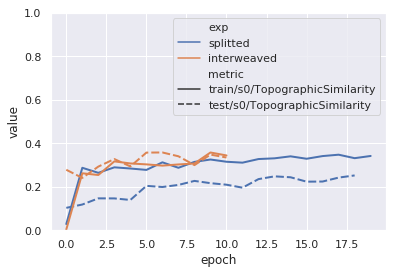

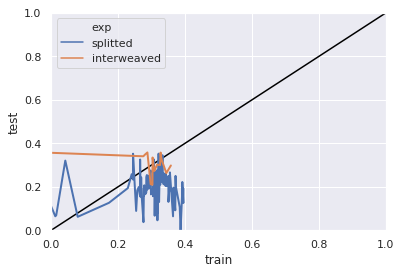

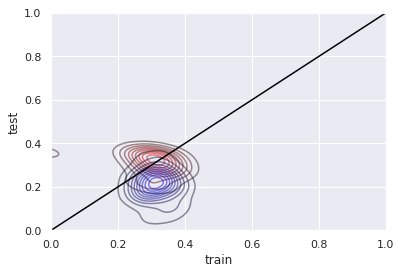

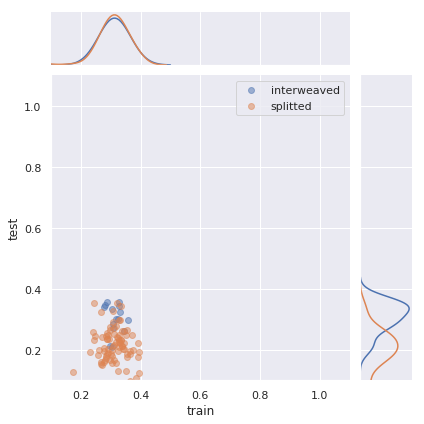

In [183]:
g_test_TS_coord_split_vs_inter = filtered_graph(combined_df_runs_coord_inter_split,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=False)

#### Results:

- (i) The difference between the train and test time TS, in the 'splitted' setting, clearly shows the lack of productivity that the emerging I-language would enables (i.e. measure compositionality in terms of the ability, at test time, to repurpose the language to novel stimuli, thus yielding a high TS measure for the test-time E-Language).

- (ii) Focusing on the accuracies, it would seem that the emerging language in the 'interweaved' setting allows the agent to generalize compositionally **when it comes to discriminating between stimuli**.


### Why is there seemingly compositional generalization when looking at the RG accuracy, while there is failure to do so when looking at the latent values prediction?

It most likely has to do with the latent axises difference in terms of value sampling size. The sampling size on the SHAPE latent axis is far smaller than that on the POSITION latent axis, which gives the architecture less opportunity to learn to generalize, thus showing that they do not generalize systematically, but rather that they pile up evidences, similarly to how RNNs do(\cite{Loula et al. 2018}).
The accuracies observed are a reflexion of the language being focused more on positioning than on shapes.

To give a greater sense of this, we test the same architecture with test samples that consist solely of stimuli of the shape (SAME_COLOR | Shapes_in_{} | SAME_SCALE | SAME_ORIENTATION | SAME_X | SAME_Y).


## Coord vs Normal:

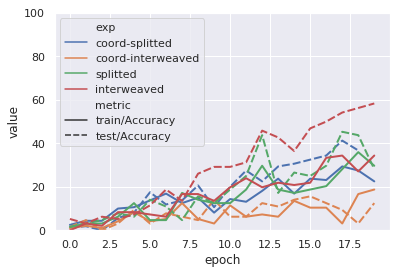

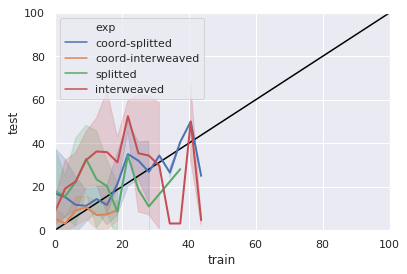

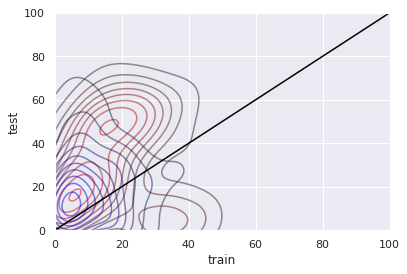

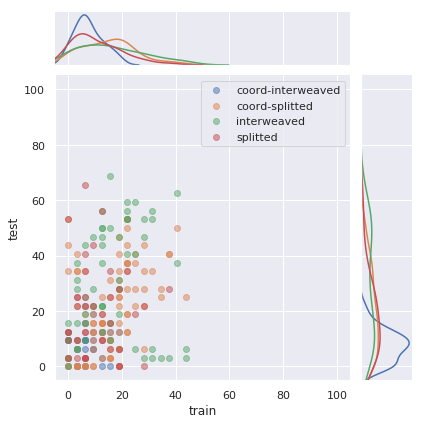

In [184]:
combined_df_runs_coord_inter_split.loc[combined_df_runs_coord_inter_split['exp'].isin(['splitted']), 'exp'] = 'coord-splitted'
combined_df_runs_coord_inter_split.loc[combined_df_runs_coord_inter_split['exp'].isin(['interweaved']), 'exp'] = 'coord-interweaved'

combined_exp1_coord_vs_simple = pd.concat([combined_df_runs_coord_inter_split, combined_df_runs_inter_split])

g_test_acc_coord_vs_normal_split_vs_inter = filtered_graph(combined_exp1_coord_vs_simple,
    filtering_keys=["test/Accuracy", "train/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True)

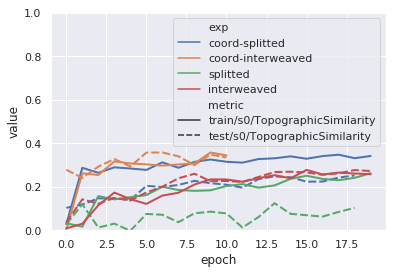

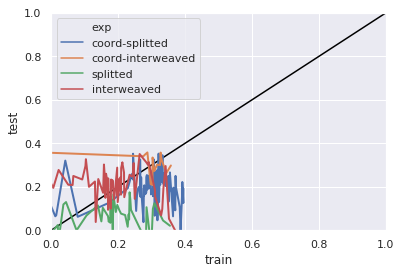

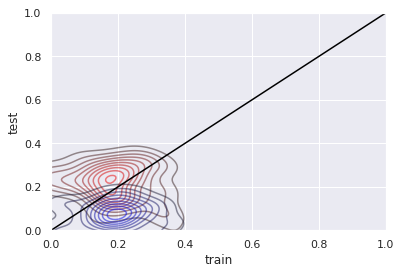

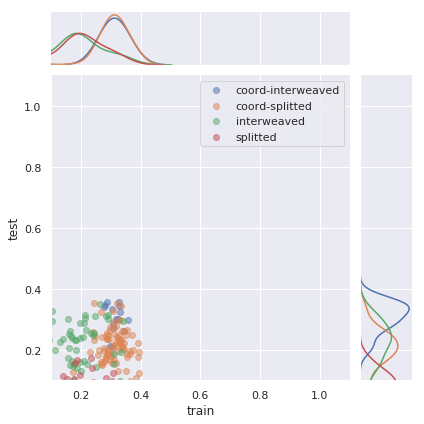

In [185]:
g_test_TS_coord_vs_normal_split_vs_inter = filtered_graph(combined_exp1_coord_vs_simple,
    filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=False)

# Experiment 2: Extrapolation to novel compositional stimuli, with both familiar and novel components

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial3-Y-4-E4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/test_combinatorial3-Y-2-S8-X-2-S8-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED10-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2/events.out.tfevents.1582899326.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial3-Y-4-E4-X-4-S4

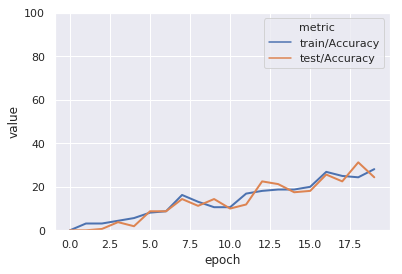

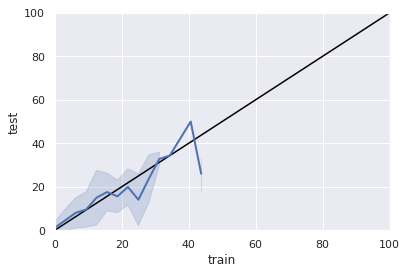

In [186]:
path_split_extra = 'PAPER/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial3-Y-4-E4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/test_combinatorial3-Y-2-S8-X-2-S8-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED40-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_ResNet18AvgPooled-2'
g_acc_split_extra, df_runs_split_extra = glob_filter_draw_acc4path(path_split_extra)

In [187]:
split_extra_length = len(df_runs_split_extra)
df_runs_split_extra_id = df_runs_split_extra.assign(exp=pd.Series(['splitted_extra']*split_extra_length))

# Making up for the extra timepoint in testing:
'''
print(df_runs_split_extra_id['timepoint'].where(['test' in v for v in df_runs_split_extra_id['metric'].values]))
print(df_runs_split_id['timepoint'].where(['test' in v for v in df_runs_split_id['metric'].values]))
lenextra = max(df_runs_split_extra_id['timepoint'].where(['test' in v for v in df_runs_split_extra_id['metric'].values]))
lennormal = max(df_runs_split_id['timepoint'].where(['test' in v for v in df_runs_split_id['metric'].values]))
divider = lenextra/lennormal
print(lenextra, lennormal, divider)
'''

df_runs_split_extra_id_reg = df_runs_split_extra_id.copy()

'''
timepoints_extra = []
for idx, value in enumerate(df_runs_split_extra_id_reg['timepoint']):
    if 'test' in df_runs_split_extra_id_reg['metric'][idx]:
        if 'Accuracy' in df_runs_split_extra_id_reg['metric'][idx]: 
            timepoints_extra.append(df_runs_split_extra_id_reg['timepoint'][idx])

timepoints = []
for idx, value in enumerate(df_runs_split_id['timepoint']):
    if 'test' in df_runs_split_id['metric'][idx]:
        if 'Accuracy' in df_runs_split_id['metric'][idx]: 
            timepoints.append(df_runs_split_id['timepoint'][idx])

print(timepoints[-1], timepoints_extra[-1])
divider = timepoints_extra[-1]/timepoints[-1]
'''

divider = 4 # in number of steps...

for idx, value in df_runs_split_extra_id_reg['step'].items():
    if 'test' in df_runs_split_extra_id_reg.loc[idx,'metric']:
        if 'Accuracy' in df_runs_split_extra_id_reg.loc[idx,'metric']: 
            df_runs_split_extra_id_reg.loc[idx,'step'] = df_runs_split_extra_id_reg.loc[idx,'step'] /divider
            
combined_df_runs_split_split_extra = pd.concat([df_runs_split_id, df_runs_split_extra_id])
combined_df_runs_split_split_extra_reg = pd.concat([df_runs_split_id, df_runs_split_extra_id_reg])

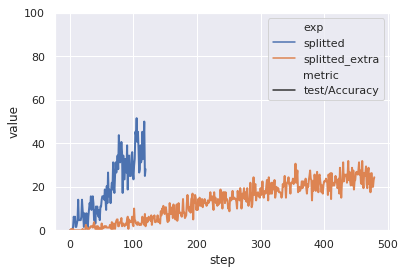

In [188]:
g_test_acc_split_vs_split_extra = filtered_graph(combined_df_runs_split_split_extra,
    filtering_keys=["test/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True)

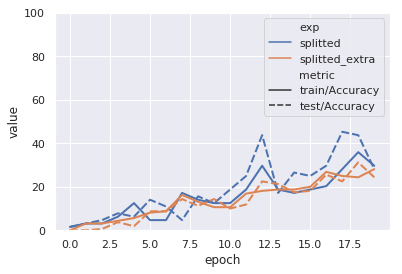

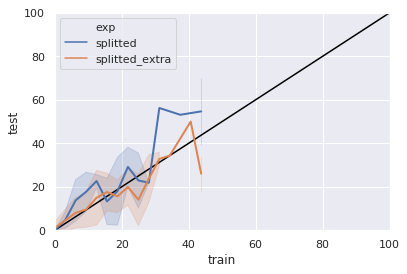

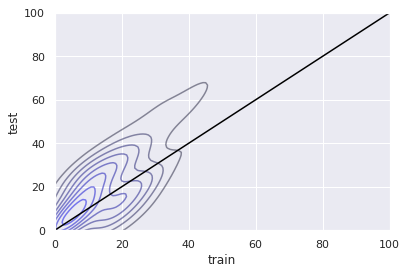

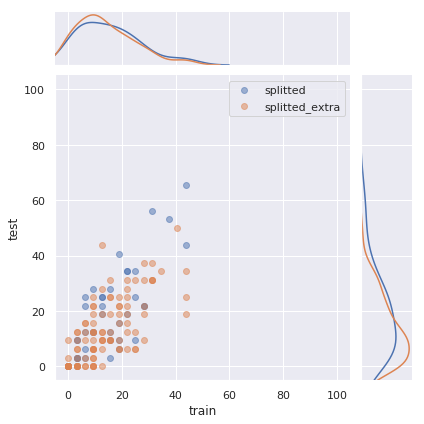

In [189]:
g_test_acc_split_vs_split_extra_reg = filtered_graph(combined_df_runs_split_split_extra_reg,
    filtering_keys=["test/Accuracy", "train/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric", 
    percentage=True)

## CoordResNet:

/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/EXP2/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/test_combinatorial3-Y-2-S8-X-2-S8-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED10-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2/events.out.tfevents.1582933522.kevin-PRIME-Z270-P
--------------------
/media/kevin/TOSHIBA_EXT1/DATA/UNI/MineRL/ReferentialGym/examples/Havrylov_et_al/test_Stop0Start0/PAPER/EXP2/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial

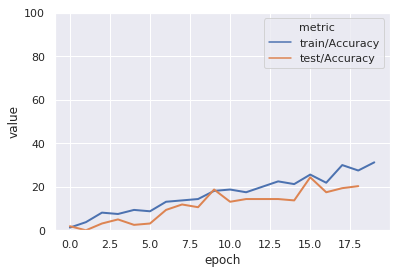

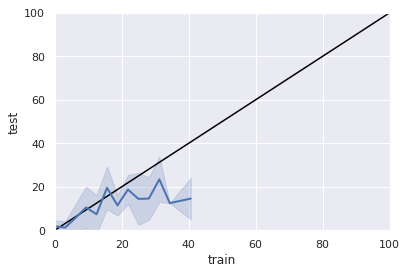

In [190]:
path_coord_split_extra = 'PAPER/EXP2/dSPrites/DualLabeled/MultiHead_Detached/20Ep_Emb256_CNN512/TrainNOTF_TestNOTF/SpBatchNormLsBatchNormOnFeatures+NOLsBatchNormOnRNNDropout0.5_DPEmb0.8_BN_learning/Hinge/dSprites/train_combinatorial3-Y-4-S4-X-4-S4-Orientation-10-N-Scale-2-N-Shape-1-3/test_combinatorial3-Y-2-S8-X-2-S8-Orientation-10-N-Scale-2-N-Shape-1-3/OBS32X1C-S1L1-None-ResetoldestL-CulturalDiffObverter0.95-2GPR-SEED50-partial-obs_b32_lr0.0003-straight_through_gumbel_softmax-tau0-0.2-uniformDistr127-stim1-vocab100over10_CoordResNet18AvgPooled-2'
g_acc_coord_split_extra, df_runs_coord_split_extra = glob_filter_draw_acc4path(path_coord_split_extra)

In [191]:
coord_split_extra_length = len(df_runs_split_extra)
df_runs_coord_split_extra_id = df_runs_coord_split_extra.assign(exp=pd.Series(['splitted_extra']*split_extra_length))

# Making up for the extra timepoint in testing:
df_runs_coord_split_extra_id_reg = df_runs_coord_split_extra_id.copy()

divider = 4 # in number of steps...

for idx, value in df_runs_coord_split_extra_id_reg['step'].items():
    if 'test' in df_runs_coord_split_extra_id_reg.loc[idx,'metric']:
        if 'Accuracy' in df_runs_coord_split_extra_id_reg.loc[idx,'metric']: 
            df_runs_coord_split_extra_id_reg.loc[idx,'step'] = df_runs_coord_split_extra_id_reg.loc[idx,'step'] /divider
            
combined_df_runs_coord_split_split_extra = pd.concat([df_runs_coord_split_id, df_runs_coord_split_extra_id])
combined_df_runs_coord_split_split_extra_reg = pd.concat([df_runs_coord_split_id, df_runs_coord_split_extra_id_reg])

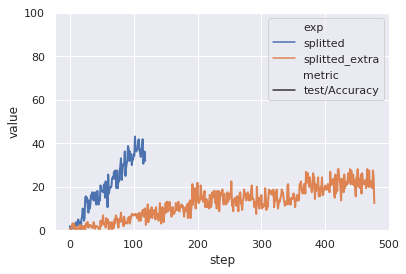

In [192]:
g_test_acc_coord_split_vs_split_extra = filtered_graph(combined_df_runs_coord_split_split_extra,
    filtering_keys=["test/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True)

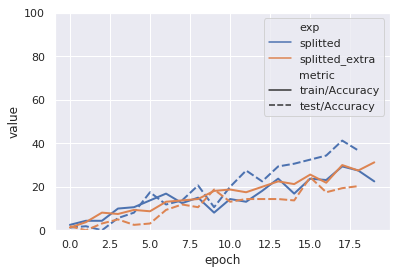

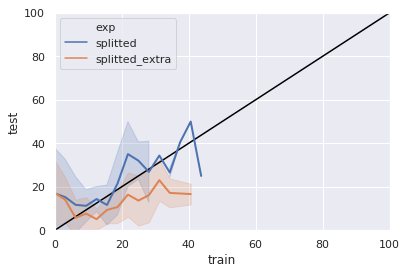

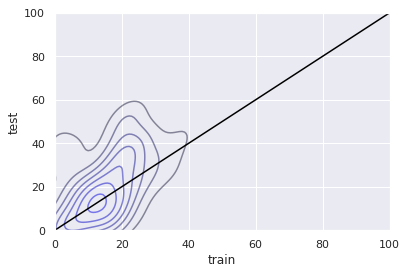

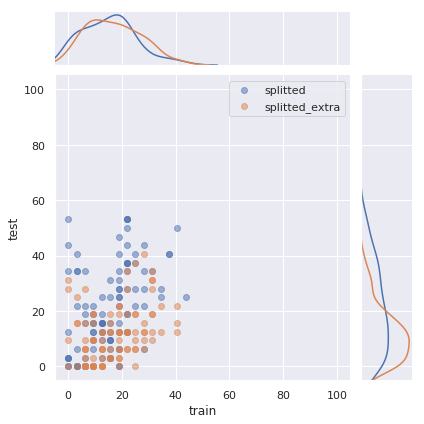

In [195]:
g_test_acc_coord_split_vs_split_extra_reg = filtered_graph(combined_df_runs_coord_split_split_extra_reg,
    filtering_keys=["test/Accuracy", "train/Accuracy"], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric", 
    percentage=True)